In [1]:
#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LassoCV
from sklearn.base import clone
from sklearn.metrics import r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA 
from sklearn.metrics import log_loss
import seaborn as sns

%matplotlib inline

In [2]:
"""
2010-2018
Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p
Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018_REDISTRICTDROP.p

2004-2018
Datasets/data_FEC_NATIONALPOLL_2004_2018.p
Datasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p
"""

'\n2010-2018\nDatasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p\nDatasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018_REDISTRICTDROP.p\n\n2004-2018\nDatasets/data_FEC_NATIONALPOLL_2004_2018.p\nDatasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p\n'

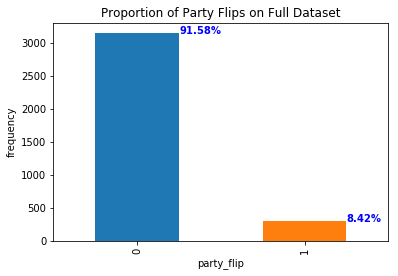

In [3]:
# Plot the proportion of flips in the full dataset

#read in FEC data
full_dataset = pickle.load(open('Datasets/data_FEC_NATIONALPOLL_2004_2018.p', 'rb'))
full_dataset_redistrict = pickle.load(open('Datasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p', 'rb'))

#add column to indicate a party flip
full_dataset['party_flip'] = (full_dataset.dem_win_prev!=full_dataset.dem_win)*1

#small_dataset.head()
plt.title('Proportion of districts that chage party in consecutive elections')
plt.ylabel('frequency')
plt.xlabel('Party Change')
full_dataset.party_flip.value_counts().plot(kind='bar')

#proportion of districts on the full data that do not flip
full_dataset.groupby('party_flip')['party_flip'].count().plot.bar()
plt.title('Proportion of Party Flips on Full Dataset')

for name, group in (full_dataset.groupby('party_flip')['party_flip']):
    plt.text(int(name)+.25, group.count() + .25, \
    '{0:.2f}'.format(group.count()/full_dataset.shape[0]*100)+'%', color='blue', fontweight='bold')

/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


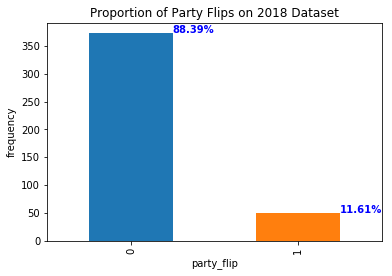

In [4]:
# Plot the proportion of flips in 2018

#add column to indicate a party flip
the_2018_dataset = full_dataset.loc[full_dataset['year']==2018,:]
the_2018_dataset.loc[:,'party_flip'] = (full_dataset.dem_win_prev!=full_dataset.dem_win)*1

#small_dataset.head()
plt.title('Proportion of districts that chage party in consecutive elections')
plt.ylabel('frequency')
plt.xlabel('Party Change')
the_2018_dataset.party_flip.value_counts().plot(kind='bar')

#proportion of districts on the full data that do not flip
the_2018_dataset.groupby('party_flip')['party_flip'].count().plot.bar()
plt.title('Proportion of Party Flips on 2018 Dataset')

for name, group in (the_2018_dataset.groupby('party_flip')['party_flip']):
    plt.text(int(name)+.25, group.count() + .25, \
    '{0:.2f}'.format(group.count()/the_2018_dataset.shape[0]*100)+'%', color='blue', fontweight='bold')

In [5]:
def upsample(test, monsterframe=False):    
    '''
    input: test (pandas.dataframe)
    output: pandas.dataframe
    
    input dataframe MUST have the columns dem_win_prev and dem_win
    function will ensure that there are an equal number of flips and no flips in the dataset via bootstrap
    '''
    
    #check if party flip as per usual
    test['party_flip'] = (test.dem_win_prev != test.dem_win)*1
    #drop 2018 rows as we want to test on these, don't mess with them
    test = test[test['year'] != 2018]
    #count number of flips and no flips
    print(np.sum((test['party_flip']==1)), np.sum((test['party_flip']==0)))
    #we want to match these counts, so we need target number of bootstrapped samples
    target = (np.sum((test['party_flip']==0))) - (np.sum((test['party_flip']==1)))
    #collect target bootstrap samples where we see a flip
    samples = test[test['party_flip'] == 1].sample(n=target, replace=True)
    #add them back to the dataframe
    test = pd.concat([test, samples])
    print(np.sum((test['party_flip']==1)), np.sum((test['party_flip']==0)))
    print(len(set(test[test['party_flip'] == 1].index)))
    test = test.drop('party_flip', axis=1)
    
    if monsterframe:
        target = 5*(len(test))
        samples = test.sample(n=target, replace=True)
        test = pd.concat([test, samples])
    print(len(test))
    
    
    
    return test

#full_dataset = boostrap(full_dataset)

## Code without demographics

* district
* state
* year
* party
* candidatevotes
* totalvotes
* candidate
* national_poll
* national_poll_prev
* national_poll_delta_subtract
* national_poll_delta_divide
* previous_party
* dem_win_margin_prev
* rep_win_margin_prev
* margin_signed_minus_prev
* margin_signed_divide_prev
* margin_unsigned_minus_prev
* margin_unsigned_divide_prev
* dem_win_prev
* rep_win_prev
* dem_win
* rep_win

## Variables to use

* national_poll
* margin_signed_minus_prev

* dem_win -- response

### Functions

In [6]:
# format data items for input into the model

def format_model_input(filename, x_cols, y_col, state_hot_encoder=False):
    
    # load full dataset 
    full_dataset = pickle.load(open(filename, 'rb'))
    
    # train data is everything except 2018
    pre_2018_dataset = full_dataset.loc[full_dataset['year']!=2018]
    pre_2018_dataset = upsample(pre_2018_dataset, monsterframe=False)

    X_train = pre_2018_dataset[cols_to_use]
    y_train = pre_2018_dataset[y_col]
    flip_train = np.abs(pre_2018_dataset['dem_win']-pre_2018_dataset['dem_win_prev'])
    
    # test data is 2018
    the_2018_dataset = full_dataset.loc[full_dataset['year']==2018]
    X_test = the_2018_dataset[cols_to_use]
    y_test = the_2018_dataset[y_col]
    flip_test = np.abs(the_2018_dataset['dem_win']-the_2018_dataset['dem_win_prev'])
    
    if state_hot_encoder:
        #add one hot encoder for states (with or without dropping first)
        X_train.loc[:,'state'] = pre_2018_dataset['state']
        X_train = pd.get_dummies(X_train,prefix='state',columns=['state'], drop_first=True)
        X_test.loc[:,'state'] = the_2018_dataset['state']
        X_test = pd.get_dummies(X_test,prefix='state',columns=['state'], drop_first=True)
    
    return X_train,y_train, X_test,y_test, flip_train,flip_test

In [7]:
def plot_metrics(model_dict, X_train_input, y_train_input, X_test_input, y_test_input, flip_train, flip_test, prob=False):
    
    df_for_plotting = pd.DataFrame()
    for model_name, model in model_dict.items():
        dict_for_plotting = {}
        # copy arrays so you don't accidentally change them 
        X_train = X_train_input.copy()
        y_train = y_train_input.copy()
        X_test = X_test_input.copy()
        y_test = y_test_input.copy()
        
        # get the flip and noflip data
        #flip_mask_train = np.array(flip_train)==1
        flip_mask_test = np.array(flip_test)==1

        # calculate metrics
        if prob==True:    
            # predict_proba test and train data
            y_prob_test = model.predict_proba(X_test)
            y_prob_train = model.predict_proba(X_train)
            
            train_score = log_loss(y_train, y_prob_train)
            test_score = log_loss(y_test, y_prob_test)
            percent_noflip_correct = log_loss(y_test[~flip_mask_test], y_prob_test[~flip_mask_test])
            percent_flip_correct = log_loss(y_test[flip_mask_test],y_prob_test[flip_mask_test])
            
            
            # train score
            dict_for_plotting['model_name'] = model_name
            dict_for_plotting['metric_name'] = 'train_logloss'
            dict_for_plotting['metric'] = train_score
            df_for_plotting = df_for_plotting.append(dict_for_plotting,ignore_index=True)

            # test score
            dict_for_plotting['model_name'] = model_name
            dict_for_plotting['metric_name'] = 'test_logloss'
            dict_for_plotting['metric'] = test_score
            df_for_plotting = df_for_plotting.append(dict_for_plotting,ignore_index=True)

            # percent noflip
            dict_for_plotting['model_name'] = model_name
            dict_for_plotting['metric_name'] = 'noflip_logloss'
            dict_for_plotting['metric'] = percent_noflip_correct
            df_for_plotting = df_for_plotting.append(dict_for_plotting,ignore_index=True)

            # percent flip
            dict_for_plotting['model_name'] = model_name
            dict_for_plotting['metric_name'] = 'flip_logloss'
            dict_for_plotting['metric'] = percent_flip_correct
            df_for_plotting = df_for_plotting.append(dict_for_plotting,ignore_index=True)
            
        else:
            # predict test and train data
            y_pred_test = model.predict(X_test)
            y_pred_train = model.predict(X_train)
            
            y_pred_train = y_pred_train.round()
            y_pred_test = y_pred_test.round()
            train_score = accuracy_score(y_train, y_pred_train)
            test_score = accuracy_score(y_test, y_pred_test)
            percent_noflip_correct = accuracy_score(y_test[~flip_mask_test], y_pred_test[~flip_mask_test])
            percent_flip_correct = accuracy_score(y_test[flip_mask_test],y_pred_test[flip_mask_test])
        
            # train score
            dict_for_plotting['model_name'] = model_name
            dict_for_plotting['metric_name'] = 'train_acc'
            dict_for_plotting['metric'] = train_score
            df_for_plotting = df_for_plotting.append(dict_for_plotting,ignore_index=True)

            # test score
            dict_for_plotting['model_name'] = model_name
            dict_for_plotting['metric_name'] = 'test_acc'
            dict_for_plotting['metric'] = test_score
            df_for_plotting = df_for_plotting.append(dict_for_plotting,ignore_index=True)

            # percent noflip
            dict_for_plotting['model_name'] = model_name
            dict_for_plotting['metric_name'] = 'noflip_acc'
            dict_for_plotting['metric'] = percent_noflip_correct
            df_for_plotting = df_for_plotting.append(dict_for_plotting,ignore_index=True)

            # percent flip
            dict_for_plotting['model_name'] = model_name
            dict_for_plotting['metric_name'] = 'flip_acc'
            dict_for_plotting['metric'] = percent_flip_correct
            df_for_plotting = df_for_plotting.append(dict_for_plotting,ignore_index=True)
        
    sns.barplot(x='model_name', y='metric', hue='metric_name', data=df_for_plotting)
    plt.show()

In [8]:
# plot flips predicted by a model

def plot_flips(X_test_input, y_test_input, y_pred_test_input, flip_train, 
               flip_test, model_name):
    
    # copy arrays so you don't accidentally change them 
    X_test = X_test_input.copy()
    y_test = y_test_input.copy()
    y_pred_test = y_pred_test_input.copy()
    
    # add flip data to the array
    X_test['party_flip'] = flip_test
    
    #looking at the missclassifications with logisticRegressionCV
    miss_class_df = X_test[y_test != y_pred_test]
    good_class_df = X_test[y_test == y_pred_test]

    #plot the flips and non flips for each data
    fig, ax = plt.subplots(1,2, figsize=(14,4))
    ax[0].set_title(model_name+' Proportion of party flips on wellclassified test data')
    ax[1].set_title(model_name+' Proportion of party flips missclassified test data')

    if not good_class_df.empty:
        good_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[0])
        for name, group in (good_class_df.groupby('party_flip')['party_flip']):
            ax[0].text(int(name)+.25, group.count() + .25, \
            '{0:.2f}'.format(group.count()/good_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')

    if not miss_class_df.empty:
        miss_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[1])
        for name, group in (miss_class_df.groupby('party_flip')['party_flip']):
            ax[1].text(int(name)+.15, group.count() + .25, \
            '{0:.2f}'.format(group.count()/miss_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')
            
    normnoflip = len(X_test[X_test['party_flip'] == 0])
    normflip = len(X_test[X_test['party_flip'] == 1])
    print('predicted correctly. does not flip.: {}'.format(len(good_class_df[good_class_df['party_flip'] == 0])/normnoflip))
    print('predicted wrongly. does not flip.: {}'.format(len(miss_class_df[miss_class_df['party_flip'] == 0])/normnoflip))
    
    print('predicted correctly. does flips.: {}'.format(len(good_class_df[good_class_df['party_flip'] == 1])/normflip))
    print('predicted wrongly. does flips.: {}'.format(len(miss_class_df[miss_class_df['party_flip'] == 1])/normflip))
        
    plt.show()

In [9]:
# print out R2, accuracy, and plot # flipped seats correctly predicted for a given model

def report_model_stats(filename, x_cols, y_col, model_dict, state_hot_encoder=False):
    
    # read in the desired data
    X_train,y_train, X_test,y_test, flip_train,flip_test = \
        format_model_input(filename, cols_to_use, y_col, state_hot_encoder)
        
    fitted_model_dict = {}
    
    for model_name, model in model_dict.items():
        model_copy = clone(model) # deep copy model to prevent fitting it twice
        print(model_name)

        fitted_model = model_copy.fit(X_train,y_train)
        y_pred_test = fitted_model.predict(X_test)

        print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred_test.round()))

#         print("\n{} R2: ".format(model_name), fitted_model.score(X_train,y_train))
#         print("{} Test Accuracy".format(model_name), accuracy_score(y_test,y_pred_test.round()))

        #plot_flips(X_test, y_test, y_pred_test.round(), flip_train, flip_test, model_name)
        
        fitted_model_dict[model_name] = fitted_model
        
        try:
            coef = fitted_model.coef_.squeeze()
            print(len(X_test.columns), len(coef))
            print('intercept = {}'.format(fitted_model.intercept_))
            print([i for i in zip(X_test.columns,coef)])
        except AttributeError:
            print('doesnt have any coefficients')
    
    plot_metrics(fitted_model_dict, X_train, y_train, X_test, y_test, flip_train, flip_test, prob=False)
    plot_metrics(fitted_model_dict, X_train, y_train, X_test, y_test, flip_train, flip_test, prob=True)
    
    return fitted_model_dict

## Try out different models and columns

### Full dataset, no demographics, not dropping any data. 

In [10]:
# specify your models here:
model_dict = {
    'LDA'           : LDA(),
    'QDA'           : QDA(),
    'kNN'           : KNeighborsClassifier(n_neighbors=1,n_jobs=4),
    'Random Forest' : RandomForestClassifier(n_jobs=4,random_state=209),
    'AdaBoost'      : AdaBoostClassifier(DecisionTreeClassifier(max_depth=10)),
}

y_col = ['dem_win']

/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarn

240 2769
2769 2769
240
5538
LDA
Confusion Matrix: 
 [[ 82 114]
 [  4 222]]
12 12
intercept = [0.99564513]
[('national_poll', 0.14260497176681305), ('national_poll_prev', -0.00018911266507978277), ('national_poll_delta_subtract', 0.06310617038074678), ('national_poll_delta_divide', 0.05571207210061773), ('dem_win_margin_prev', 1.1882967752142233), ('rep_win_margin_prev', -4.400702508093385), ('margin_signed_minus_prev', 1.4297488250088555), ('margin_signed_divide_prev', -3.3804272905695947e-10), ('margin_unsigned_minus_prev', -0.44811406119830854), ('margin_unsigned_divide_prev', 1.834761933474401e-10), ('dem_win_prev', -0.7942663880627441), ('rep_win_prev', 0.794266388062744)]
QDA
Confusion Matrix: 
 [[188   8]
 [ 41 185]]
doesnt have any coefficients
kNN
Confusion Matrix: 
 [[169  27]
 [ 35 191]]
doesnt have any coefficients
Random Forest
Confusion Matrix: 
 [[176  20]
 [ 36 190]]
doesnt have any coefficients
AdaBoost


/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix: 
 [[189   7]
 [ 41 185]]
doesnt have any coefficients


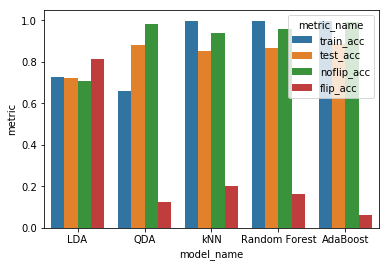

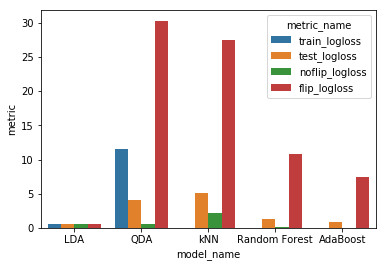

{'LDA': LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
               solver='svd', store_covariance=False, tol=0.0001),
 'QDA': QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                store_covariance=False, store_covariances=None, tol=0.0001),
 'kNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=4, n_neighbors=1, p=2,
            weights='uniform'),
 'Random Forest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
             oob_score=False, random_state=209, verbose=0, warm_start=False),
 'AdaBoost': AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier

In [11]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_2004_2018.p'
cols_to_use = ['national_poll', 'national_poll_prev',
       'national_poll_delta_subtract', 'national_poll_delta_divide',
       'dem_win_margin_prev', 'rep_win_margin_prev',
       'margin_signed_minus_prev', 'margin_signed_divide_prev',
       'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev',
       'dem_win_prev', 'rep_win_prev'] # all of them
state_hot_encoder = False


report_model_stats(filename, cols_to_use, y_col, model_dict, state_hot_encoder)

### Full dataset, no demographics, dropping redistricted states

/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarn

167 2436
2436 2436
167
4872
LDA
Confusion Matrix: 
 [[108  79]
 [  1 216]]
12 12
intercept = [0.25542603]
[('national_poll', 0.2232829254488316), ('national_poll_prev', 0.028090182567320418), ('national_poll_delta_subtract', 0.09350855384816531), ('national_poll_delta_divide', -0.05809863226580876), ('dem_win_margin_prev', 2.456693749378716), ('rep_win_margin_prev', -4.825400971246671), ('margin_signed_minus_prev', 1.8747429991878204), ('margin_signed_divide_prev', -5.041546363531861e-10), ('margin_unsigned_minus_prev', -0.6477125105536784), ('margin_unsigned_divide_prev', 1.9082286179534593e-10), ('dem_win_prev', -0.7272752263023787), ('rep_win_prev', 0.7272752263023794)]
QDA
Confusion Matrix: 
 [[187   0]
 [217   0]]
doesnt have any coefficients
kNN
Confusion Matrix: 
 [[164  23]
 [ 29 188]]
doesnt have any coefficients
Random Forest
Confusion Matrix: 
 [[184   3]
 [ 34 183]]
doesnt have any coefficients
AdaBoost


/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix: 
 [[184   3]
 [ 36 181]]
doesnt have any coefficients


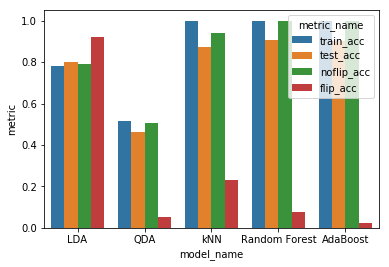

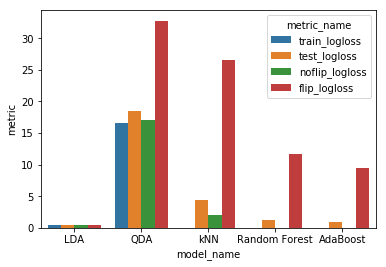

{'LDA': LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
               solver='svd', store_covariance=False, tol=0.0001),
 'QDA': QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                store_covariance=False, store_covariances=None, tol=0.0001),
 'kNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=4, n_neighbors=1, p=2,
            weights='uniform'),
 'Random Forest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
             oob_score=False, random_state=209, verbose=0, warm_start=False),
 'AdaBoost': AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier

In [12]:
# specify columns to use and the file you want to read in 
filename = 'Datasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p'
state_hot_encoder = False # some states get dropped so this leads to problems
cols_to_use = ['national_poll', 'national_poll_prev',
       'national_poll_delta_subtract', 'national_poll_delta_divide',
       'dem_win_margin_prev', 'rep_win_margin_prev',
       'margin_signed_minus_prev', 'margin_signed_divide_prev',
       'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev',
       'dem_win_prev', 'rep_win_prev'] # all of them

report_model_stats(filename, cols_to_use, y_col, model_dict, state_hot_encoder)

### Selected columns in the full dataset, no demographics

/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

240 2769
2769 2769
240
5538
LDA
Confusion Matrix: 
 [[135  61]
 [ 14 212]]
51 51
intercept = [-3.29533015]
[('national_poll', 0.25428516201233126), ('margin_signed_minus_prev', 2.1298649889455348), ('state_AL', 1.4896426819043758), ('state_AR', 0.3503035043727226), ('state_AZ', 2.38112945279142), ('state_CA', 2.9436762274522783), ('state_CO', 2.7147815099712007), ('state_CT', 3.9699907423991148), ('state_DE', 4.939600855546366), ('state_FL', 2.7447313755486404), ('state_GA', 1.69866701568141), ('state_HI', 4.4734158373989406), ('state_IA', 2.0246448662975025), ('state_ID', 1.6280805734941852), ('state_IL', 2.827240396943392), ('state_IN', 1.6788682662625325), ('state_KS', 0.8917440965305583), ('state_KY', 1.7657064337495023), ('state_LA', 1.1052831209702259), ('state_MA', 4.266827825976973), ('state_MD', 3.8278009036216654), ('state_ME', 1.8035596726777636), ('state_MI', 1.815306216636956), ('state_MN', 2.762959871048975), ('state_MO', 1.1890606428134967), ('state_MS', 1.95502831217403

/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/ipyke

Confusion Matrix: 
 [[178  18]
 [ 37 189]]
doesnt have any coefficients
Random Forest


/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


Confusion Matrix: 
 [[183  13]
 [ 40 186]]
doesnt have any coefficients
AdaBoost


/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix: 
 [[184  12]
 [ 39 187]]
doesnt have any coefficients


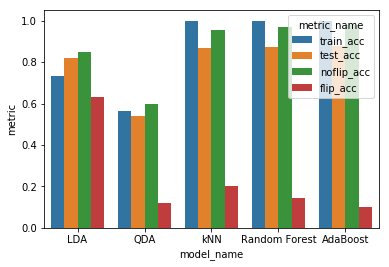

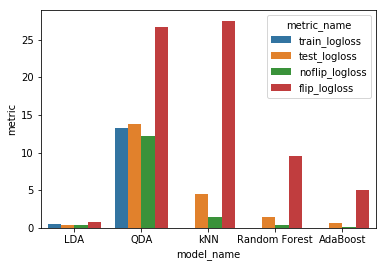

{'LDA': LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
               solver='svd', store_covariance=False, tol=0.0001),
 'QDA': QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                store_covariance=False, store_covariances=None, tol=0.0001),
 'kNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=4, n_neighbors=1, p=2,
            weights='uniform'),
 'Random Forest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
             oob_score=False, random_state=209, verbose=0, warm_start=False),
 'AdaBoost': AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier

In [13]:
filename = 'Datasets/data_FEC_NATIONALPOLL_2004_2018.p'
cols_to_use = ['national_poll', 'margin_signed_minus_prev']
state_hot_encoder = True

report_model_stats(filename, cols_to_use, y_col, model_dict, state_hot_encoder)

### Selected columns in the full dataset, no demographics, dropping redistricted states

/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Elise

167 2436
2436 2436
167
4872
LDA
Confusion Matrix: 
 [[109  78]
 [  1 216]]
2 2
intercept = [-1.43441515]
[('national_poll', 0.3208557710341452), ('margin_signed_minus_prev', 3.0890710703447564)]
QDA
Confusion Matrix: 
 [[119  68]
 [  2 215]]
doesnt have any coefficients
kNN
Confusion Matrix: 
 [[176  11]
 [ 32 185]]
doesnt have any coefficients
Random Forest
Confusion Matrix: 
 [[171  16]
 [ 32 185]]
doesnt have any coefficients
AdaBoost


/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix: 
 [[182   5]
 [ 32 185]]
doesnt have any coefficients


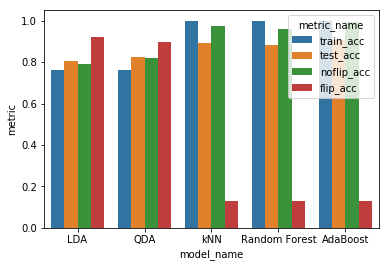

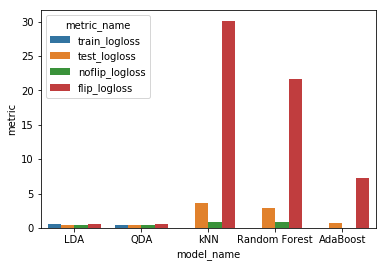

{'LDA': LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
               solver='svd', store_covariance=False, tol=0.0001),
 'QDA': QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                store_covariance=False, store_covariances=None, tol=0.0001),
 'kNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=4, n_neighbors=1, p=2,
            weights='uniform'),
 'Random Forest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
             oob_score=False, random_state=209, verbose=0, warm_start=False),
 'AdaBoost': AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier

In [14]:
filename = 'Datasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p'
cols_to_use = ['national_poll', 'margin_signed_minus_prev']
state_hot_encoder = False

report_model_stats(filename, cols_to_use, y_col, model_dict, state_hot_encoder)

### Selected columns in the full dataset, no demographics, imputing redistricted states

### Dataset since 2010, with demographics, nothing dropped

columns in demographics


['district', 'state', 'year', 'party', 'candidatevotes', 'totalvotes',
       'candidate', 'national_poll', 'national_poll_prev',
       'national_poll_delta_subtract', 'national_poll_delta_divide',
       'previous_party', 'dem_win_margin_prev', 'rep_win_margin_prev',
       'margin_signed_minus_prev', 'margin_signed_divide_prev',
       'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev',
       'dem_win_prev', 'rep_win_prev', 'dem_win', 'rep_win', 'female_pct',
       'age18_24_pct', 'age25_34_pct', 'median_age', 'unmarried_partner_pct',
       'male_living_alone_pct', 'bachelors_deg_or_higher_pct',
       'past_year_births_to_unmarried_women_pct', 'civilian_veteran_pct',
       'live_same_house_past_year_pct',
       'foreign_born_proportion_from_LatinAmerica',
       'speak_other_language_at_home_pct', 'labor_force_unemployed_pct',
       'public_transit_commuter_pct', 'no_health_insurance_pct',
       'poverty_rate_pct', 'median_housing_value', 'median_household_income',
       'food_stamp_benefits_pct', 'foreign_to_native_born_ratio']

In [15]:
filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p'
cols_to_use = ['national_poll', 'national_poll_prev', 'national_poll_delta_subtract', 
               'national_poll_delta_divide', 'dem_win_margin_prev', 'rep_win_margin_prev',
               'margin_signed_minus_prev', 'margin_signed_divide_prev', 
               'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev', 
               'dem_win_prev', 'rep_win_prev', 'female_pct', 'age18_24_pct', 
               'age25_34_pct', 'median_age', 'unmarried_partner_pct', 
               'male_living_alone_pct', 'bachelors_deg_or_higher_pct', 
               'civilian_veteran_pct', #'past_year_births_to_unmarried_women_pct', # has a string in it
               'live_same_house_past_year_pct', 
               'foreign_born_proportion_from_LatinAmerica', 
               'speak_other_language_at_home_pct', 'labor_force_unemployed_pct', 
               'public_transit_commuter_pct', 'no_health_insurance_pct', 
                'poverty_rate_pct', 'median_household_income', # 'median_housing_value', # has a string in it
                'food_stamp_benefits_pct', 'foreign_to_native_born_ratio' 
              ] # everything

/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarn

161 1543
1543 1543
161
3086
LDA
Confusion Matrix: 
 [[  0 196]
 [  0 226]]
30 30
intercept = [-92.34255018]
[('national_poll', 6.632098550561639), ('national_poll_prev', 2.095038629250995), ('national_poll_delta_subtract', -0.37294422679779604), ('national_poll_delta_divide', -5.898761330632282), ('dem_win_margin_prev', 3.796147359229101), ('rep_win_margin_prev', -0.5843590967034293), ('margin_signed_minus_prev', 1.113067369281726), ('margin_signed_divide_prev', -4.771167853290745e-10), ('margin_unsigned_minus_prev', -0.5979235293093627), ('margin_unsigned_divide_prev', 3.121490160932841e-10), ('dem_win_prev', -0.8844172052948356), ('rep_win_prev', 0.8844172052948469), ('female_pct', 0.7237370737495383), ('age18_24_pct', 0.3038300534158499), ('age25_34_pct', 0.243339024940537), ('median_age', 0.0614354220295754), ('unmarried_partner_pct', 1.7470781477301789), ('male_living_alone_pct', 0.22739001560567815), ('bachelors_deg_or_higher_pct', 0.07735537772743808), ('civilian_veteran_pct', 0

/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix: 
 [[192   4]
 [ 45 181]]
doesnt have any coefficients


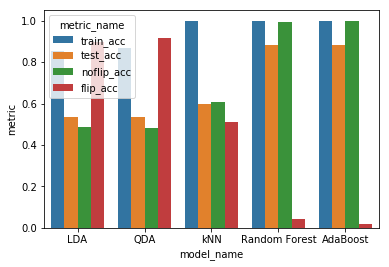

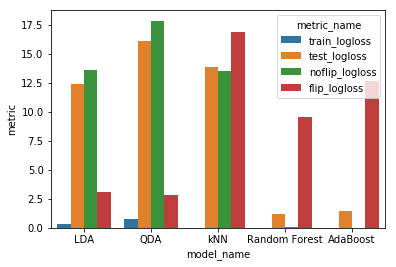

{'LDA': LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
               solver='svd', store_covariance=False, tol=0.0001),
 'QDA': QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                store_covariance=False, store_covariances=None, tol=0.0001),
 'kNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=4, n_neighbors=1, p=2,
            weights='uniform'),
 'Random Forest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
             oob_score=False, random_state=209, verbose=0, warm_start=False),
 'AdaBoost': AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier

In [16]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p'
#cols_to_use = [] # todo
state_hot_encoder = False

report_model_stats(filename, cols_to_use, y_col, model_dict, state_hot_encoder)

### Dataset since 2010, with demographics, dropping redistricted states

/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarn

96 1249
1249 1249
96
2498
LDA
Confusion Matrix: 
 [[  0 187]
 [  0 217]]
30 30
intercept = [-82.69687614]
[('national_poll', 11.921884624739587), ('national_poll_prev', 4.255705899391635), ('national_poll_delta_subtract', -0.22875999712911216), ('national_poll_delta_divide', -11.335492994312371), ('dem_win_margin_prev', 0.13860492795876916), ('rep_win_margin_prev', -5.533824769540108), ('margin_signed_minus_prev', 1.41843116358162), ('margin_signed_divide_prev', -4.4682806676992907e-10), ('margin_unsigned_minus_prev', -0.3579620341077738), ('margin_unsigned_divide_prev', 2.2980349407784642e-10), ('dem_win_prev', -0.5610216417168062), ('rep_win_prev', 0.5610216417168352), ('female_pct', 0.748128757285405), ('age18_24_pct', 0.3575956367555972), ('age25_34_pct', 0.2964081240149877), ('median_age', 0.06915151565338788), ('unmarried_partner_pct', 1.4262065095064722), ('male_living_alone_pct', 0.0667831490442927), ('bachelors_deg_or_higher_pct', 0.033068172635469385), ('civilian_veteran_pct'

/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix: 
 [[185   2]
 [ 38 179]]
doesnt have any coefficients


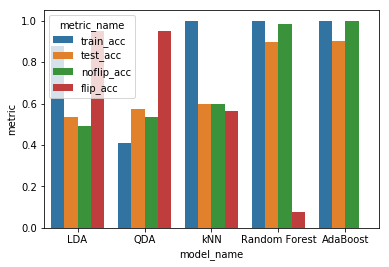

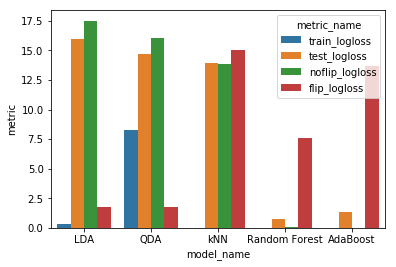

{'LDA': LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
               solver='svd', store_covariance=False, tol=0.0001),
 'QDA': QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                store_covariance=False, store_covariances=None, tol=0.0001),
 'kNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=4, n_neighbors=1, p=2,
            weights='uniform'),
 'Random Forest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
             oob_score=False, random_state=209, verbose=0, warm_start=False),
 'AdaBoost': AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier

In [17]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018_REDISTRICTDROP.p'
cols_to_use = ['national_poll', 'national_poll_prev', 'national_poll_delta_subtract', 
               'national_poll_delta_divide', 'dem_win_margin_prev', 'rep_win_margin_prev',
               'margin_signed_minus_prev', 'margin_signed_divide_prev', 
               'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev', 
               'dem_win_prev', 'rep_win_prev', 'female_pct', 'age18_24_pct', 
               'age25_34_pct', 'median_age', 'unmarried_partner_pct', 
               'male_living_alone_pct', 'bachelors_deg_or_higher_pct', 
               'civilian_veteran_pct', #'past_year_births_to_unmarried_women_pct', # has a string in it
               'live_same_house_past_year_pct', 
               'foreign_born_proportion_from_LatinAmerica', 
               'speak_other_language_at_home_pct', 'labor_force_unemployed_pct', 
               'public_transit_commuter_pct', 'no_health_insurance_pct', 
                'poverty_rate_pct', 'median_household_income', # 'median_housing_value', # has a string in it
                'food_stamp_benefits_pct', 'foreign_to_native_born_ratio' 
              ] # everything
state_hot_encoder = False

report_model_stats(filename, cols_to_use, y_col, model_dict, state_hot_encoder)

### Selected columns in dataset since 2010, with demographics, nothing dropped

/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

161 1543
1543 1543
161
3086
LDA
Confusion Matrix: 
 [[144  52]
 [ 17 209]]
60 60
intercept = [-35.29566865]
[('national_poll', 0.4270730580132056), ('margin_signed_minus_prev', 2.238325872765932), ('dem_win_prev', -1.0811315741364167), ('female_pct', 0.5495737863746157), ('civilian_veteran_pct', -0.22789688297015934), ('foreign_to_native_born_ratio', 2.4438507197851256), ('labor_force_unemployed_pct', 0.41048981682325825), ('age18_24_pct', 0.16629948563284302), ('bachelors_deg_or_higher_pct', 0.06297911105487417), ('age25_34_pct', 0.32860981093667413), ('median_household_income', -4.429500433074558e-05), ('state_AL', -0.7075323505813425), ('state_AR', -1.4797569782879827), ('state_AZ', 1.3557061106885393), ('state_CA', 1.0515636454482038), ('state_CO', 0.4759275193352338), ('state_CT', 5.544536365014308), ('state_DE', 7.190380571941546), ('state_FL', 1.137929423614355), ('state_GA', -0.7691852586310544), ('state_HI', 7.170536909009612), ('state_IA', 0.6764674274436403), ('state_ID', -0

/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/ipyke

Confusion Matrix: 
 [[192   4]
 [ 47 179]]
doesnt have any coefficients
AdaBoost


/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix: 
 [[191   5]
 [ 43 183]]
doesnt have any coefficients


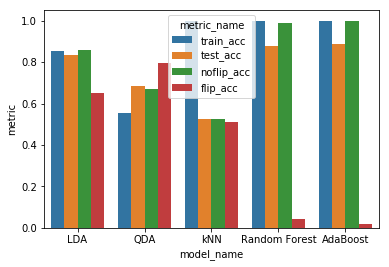

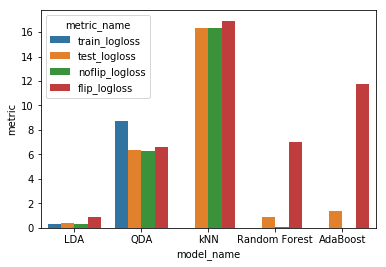

{'LDA': LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
               solver='svd', store_covariance=False, tol=0.0001),
 'QDA': QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                store_covariance=False, store_covariances=None, tol=0.0001),
 'kNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=4, n_neighbors=1, p=2,
            weights='uniform'),
 'Random Forest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
             oob_score=False, random_state=209, verbose=0, warm_start=False),
 'AdaBoost': AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier

In [18]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p'
cols_to_use = ['national_poll', 'margin_signed_minus_prev', 'dem_win_prev', 
               'female_pct', 'civilian_veteran_pct', 'foreign_to_native_born_ratio', 'labor_force_unemployed_pct',
               'age18_24_pct', 'bachelors_deg_or_higher_pct', 'age25_34_pct', 'median_household_income']
state_hot_encoder = True

report_model_stats(filename, cols_to_use, y_col, model_dict, state_hot_encoder)

### Selected columns in dataset since 2010, with demographics, dropping redistricted states

/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Elise

161 1543
1543 1543
161
3086
LDA
Confusion Matrix: 
 [[107  89]
 [  9 217]]
11 11
intercept = [-28.35589426]
[('national_poll', 0.43335281431464334), ('margin_signed_minus_prev', 2.6184419539472583), ('dem_win_prev', -1.0314192196289795), ('female_pct', 0.3900407510962509), ('civilian_veteran_pct', -0.044159916924638894), ('foreign_to_native_born_ratio', 3.728762292979682), ('labor_force_unemployed_pct', 0.4093296450194648), ('age18_24_pct', 0.22351368435574775), ('bachelors_deg_or_higher_pct', 0.08272956982078616), ('age25_34_pct', 0.1679044008630018), ('median_household_income', -2.1856239995645213e-05)]
QDA
Confusion Matrix: 
 [[178  18]
 [ 62 164]]
doesnt have any coefficients
kNN
Confusion Matrix: 
 [[120  76]
 [124 102]]
doesnt have any coefficients
Random Forest
Confusion Matrix: 
 [[190   6]
 [ 49 177]]
doesnt have any coefficients
AdaBoost


/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix: 
 [[192   4]
 [ 45 181]]
doesnt have any coefficients


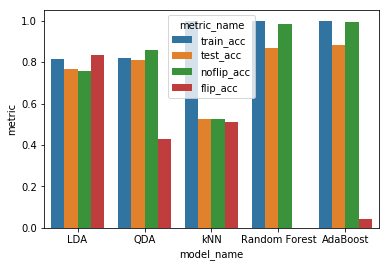

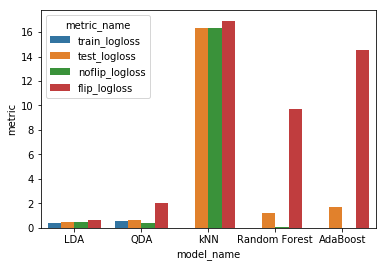

{'LDA': LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
               solver='svd', store_covariance=False, tol=0.0001),
 'QDA': QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                store_covariance=False, store_covariances=None, tol=0.0001),
 'kNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=4, n_neighbors=1, p=2,
            weights='uniform'),
 'Random Forest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
             oob_score=False, random_state=209, verbose=0, warm_start=False),
 'AdaBoost': AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier

In [19]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p'
cols_to_use = ['national_poll', 'margin_signed_minus_prev', 'dem_win_prev', 
               'female_pct', 'civilian_veteran_pct', 'foreign_to_native_born_ratio', 'labor_force_unemployed_pct',
               'age18_24_pct', 'bachelors_deg_or_higher_pct', 'age25_34_pct', 'median_household_income'] 
state_hot_encoder = False

report_model_stats(filename, cols_to_use, y_col, model_dict, state_hot_encoder)

## Impute 2010 data into all non-redistricted districts in prior years. 

### Dataset since 2004, with demographics imputed, redistrited states not dropped

/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

240 2769
2769 2769
240
5538
LDA
Confusion Matrix: 
 [[146  50]
 [ 30 196]]
60 60
intercept = [-21.97322539]
[('national_poll', 0.238900300435072), ('margin_signed_minus_prev', 2.573340278011968), ('dem_win_prev', -1.2984023921140464), ('female_pct', 0.33803413907092095), ('civilian_veteran_pct', -0.15646789016651455), ('foreign_to_native_born_ratio', 0.9185489250680121), ('labor_force_unemployed_pct', 0.0809671719877518), ('age18_24_pct', 0.12298011116422411), ('bachelors_deg_or_higher_pct', 0.02027931211480154), ('age25_34_pct', 0.2692581928465084), ('median_household_income', -3.150542389177055e-05), ('state_AL', 0.7264411350367226), ('state_AR', -0.18650816387002872), ('state_AZ', 2.322144961397205), ('state_CA', 2.02243958558113), ('state_CO', 2.193175931678793), ('state_CT', 4.188278378774096), ('state_DE', 5.762591396903991), ('state_FL', 1.9018783761116507), ('state_GA', 0.8135980769129014), ('state_HI', 5.79558483253841), ('state_IA', 1.3009956271361656), ('state_ID', 1.3468459

/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/ipyke

Confusion Matrix: 
 [[117  79]
 [120 106]]
doesnt have any coefficients
Random Forest


/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


Confusion Matrix: 
 [[192   4]
 [ 48 178]]
doesnt have any coefficients
AdaBoost


/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix: 
 [[191   5]
 [ 44 182]]
doesnt have any coefficients


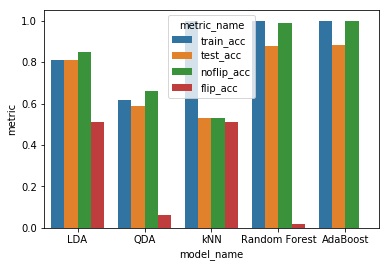

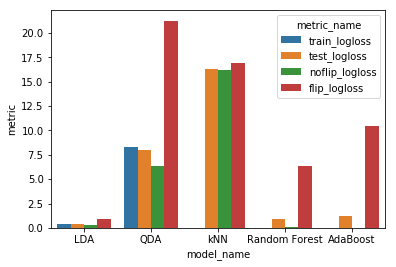

{'LDA': LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
               solver='svd', store_covariance=False, tol=0.0001),
 'QDA': QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                store_covariance=False, store_covariances=None, tol=0.0001),
 'kNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=4, n_neighbors=1, p=2,
            weights='uniform'),
 'Random Forest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
             oob_score=False, random_state=209, verbose=0, warm_start=False),
 'AdaBoost': AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier

In [20]:
filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICSIMPUTED_2004_2018.p'
cols_to_use = ['national_poll', 'margin_signed_minus_prev', 'dem_win_prev', 
               'female_pct', 'civilian_veteran_pct', 'foreign_to_native_born_ratio', 'labor_force_unemployed_pct',
               'age18_24_pct', 'bachelors_deg_or_higher_pct', 'age25_34_pct', 'median_household_income']
state_hot_encoder = True
report_model_stats(filename, cols_to_use, y_col, model_dict, state_hot_encoder)

### Dataset since 2004, with demographics imputed, redistrited states dropped

/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Elise

167 2436
2436 2436
167
4872
LDA
Confusion Matrix: 
 [[127  60]
 [  3 214]]
11 11
intercept = [-13.95131761]
[('national_poll', 0.3068663491347293), ('margin_signed_minus_prev', 3.9160279275824093), ('dem_win_prev', -1.0436956894249398), ('female_pct', 0.19502611733966696), ('civilian_veteran_pct', -0.051693866748734676), ('foreign_to_native_born_ratio', 1.3103125898339116), ('labor_force_unemployed_pct', 0.0913944976943209), ('age18_24_pct', 0.10605681658299697), ('bachelors_deg_or_higher_pct', 0.02276288799265526), ('age25_34_pct', 0.06761442661088365), ('median_household_income', 6.91535033687296e-06)]
QDA
Confusion Matrix: 
 [[165  22]
 [ 28 189]]
doesnt have any coefficients
kNN
Confusion Matrix: 
 [[111  76]
 [116 101]]
doesnt have any coefficients
Random Forest
Confusion Matrix: 
 [[186   1]
 [ 41 176]]
doesnt have any coefficients
AdaBoost


/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix: 
 [[185   2]
 [ 35 182]]
doesnt have any coefficients


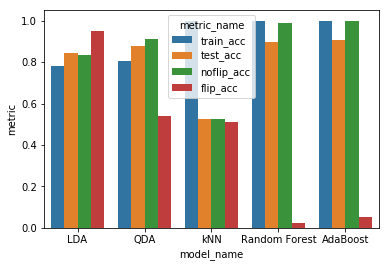

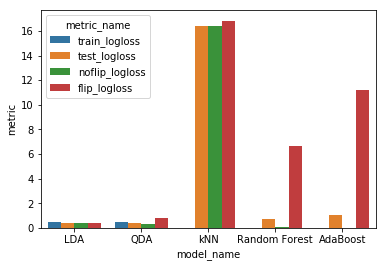

{'LDA': LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
               solver='svd', store_covariance=False, tol=0.0001),
 'QDA': QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                store_covariance=False, store_covariances=None, tol=0.0001),
 'kNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=4, n_neighbors=1, p=2,
            weights='uniform'),
 'Random Forest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
             oob_score=False, random_state=209, verbose=0, warm_start=False),
 'AdaBoost': AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier

In [21]:
filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICSIMPUTED_2004_2018_REDISTRICTDROP.p'
cols_to_use = ['national_poll', 'margin_signed_minus_prev', 'dem_win_prev', 
               'female_pct', 'civilian_veteran_pct', 'foreign_to_native_born_ratio', 'labor_force_unemployed_pct',
               'age18_24_pct', 'bachelors_deg_or_higher_pct', 'age25_34_pct', 'median_household_income']
state_hot_encoder = False
report_model_stats(filename, cols_to_use, y_col, model_dict, state_hot_encoder)

Idea: variable which is # of tims a district flipped in prior years... or something

## Try different k's for kNN 

In [22]:
cols_to_use.append('latitude')
cols_to_use.append('longitude')
cols_to_use

['national_poll',
 'margin_signed_minus_prev',
 'dem_win_prev',
 'female_pct',
 'civilian_veteran_pct',
 'foreign_to_native_born_ratio',
 'labor_force_unemployed_pct',
 'age18_24_pct',
 'bachelors_deg_or_higher_pct',
 'age25_34_pct',
 'median_household_income',
 'latitude',
 'longitude']

In [23]:
filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICSIMPUTED_2004_2018_REDISTRICTDROP.p'
ks = np.arange(1,30, 5)
state_hot_encoder = False

model_dict = {}

def mydist(x, y):
    if all(x == y):
        #bootstrap sample likely
        return 1e10
    lonx, latx = x[-2:]
    lony, laty = y[-2:]
    
    return ((lonx-lony)**2 + (latx-laty)**2)**0.5
    
for ka in ks:
    
    model_dict['knn{}'.format(ka)] = KNeighborsClassifier(n_neighbors=ka,n_jobs=4, metric=mydist)

fitted_models = report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder)

/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


167 2436
2436 2436
167
4872


TypeError: unhashable type: 'dict'

In [ ]:
filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICSIMPUTED_2004_2018_REDISTRICTDROP.p'
ks = np.arange(1,30, 5)
state_hot_encoder = False

model_dict = {}

def mydist(x, y):
    if all(x == y):
        #bootstrap sample likely
        return 1e10
    lonx, latx = x[-2:]
    lony, laty = y[-2:]
    
    return ((lonx-lony)**2 + (latx-laty)**2)**0.5
    
for ka in ks:
    
    model_dict['knn{}'.format(ka)] = KNeighborsClassifier(n_neighbors=ka,n_jobs=4, metric=mydist)

fitted_models = report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder)

###  NOTES:

1. Logistic CV 90% of the missclassified data occurs when there is a change of party compared to the previous year. No state flips are predicted correctly. 
2. KNN, 100% of the missclassified data occurs when there is a change of party. 5% of the well classified data is party flip. (Better performance)
3. Predicts correctly 100% of the districts that do not change, and ...

Concentrate on improving the states that flip to a different party between elections

Ideas
0. Try non-linear approaches (KNN, Random Forest and Boosting)
1. Increase data by Upsampling and downsampling
2. Increase data by adding more historical data
3. Add demographics data
4. Add redistricting